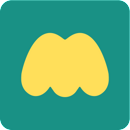

# Modak - data engineer challenge

## 1. Libs

In [167]:
import json
import calendar
import numpy as np
import pandas as pd
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data loading

In [168]:
allowance_backend_table = pd.read_csv('data/allowance_backend_table.csv')
allowance_backend_table.head()

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
0,30f4e25e-3e37-462e-8c3c-42f24f54350f,1724838709,monthly,fifteenth_day,2024-10-15T08:00:41.445627563Z,15,enabled
1,6da398ad-079d-49b9-8668-6d7ce4d22683,1724659829,monthly,fifteenth_day,1724659829,15,enabled
2,2d30fe2d-6c32-4b8a-a19b-906184f64f62,1731309159,monthly,fifteenth_day,1731309159,15,enabled
3,c30180f3-b35c-470c-b25a-f12ec4ce3340,1725414982,monthly,first_day,2024-10-01T08:00:37.516552581Z,1,enabled
4,9f5768db-e953-4057-9fa5-264c46293fbd,1726267511,biweekly,friday,2024-10-02T02:33:10.97923183Z,11,disabled


In [169]:
payment_schedule_backend_table = pd.read_csv('data/payment_schedule_backend_table.csv')
payment_schedule_backend_table.head()

,user_id,payment_date
0,061d8039-b332-40ca-b906-3514b06411c2,22
1,0ca92d01-feed-42e5-b90c-299b615f9d3f,22
2,160bcd2d-3ab0-4a60-9bfa-ccfcc1ee17e4,22
3,1649fee7-c424-4fb7-ac84-db36e15e042a,22
4,1d647703-874d-4744-b4de-6a5212518aa8,22


In [170]:
with open('data/allowance_events.json') as f:
    allowance_events_json = json.load(f)
allowance_events = pd.json_normalize(allowance_events_json)
allowance_events.head()

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
0,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-21 1:39:34,allowance.created,weekly,sunday,10
1,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
2,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
3,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:28,allowance.created,biweekly,friday,10
4,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:37,allowance.edited,weekly,friday,10


## 3. Data transformation / EDA

In [171]:
def parse_unix_or_date(val):
    """
    Convert a mixed-format value from the updated_at column to a datetime.
    If the value is numeric (or a numeric string), treat it as a Unix timestamp.
    Otherwise, assume it's an ISO-formatted datetime string.
    """
    # Check if the value is a string and represents digits only.
    if isinstance(val, str) and val.isdigit():
        return pd.to_datetime(val, unit='s')
    # If the value is already numeric, convert from Unix timestamp.
    elif isinstance(val, (int, float)):
        return pd.to_datetime(val, unit='s')
    else:
        # Otherwise, attempt to parse as a datetime string.
        return pd.to_datetime(val, errors='coerce', format='ISO8601')

#### Allowance Backend Table (`allowance_backend_table`)  
* Purpose: Stores the current allowance settings for each user, reflecting their 
most recent allowance configuration.  
* Operation:  
  * When a user creates or edits an allowance, this table should be updated 
to reflect the latest `frequency`, `day`, and `next_payment_day`.  
  * The `next_payment_day` field should accurately represent the upcoming 
payment date based on the user's allowance settings.  
  * The allowances get created with the `status` column `enabled`, but the 
users can turn them to `disabled`. Make sure you only use the enabled 
allowances.  
* Potential Issues:  
  * Discrepancies during the affected period may have resulted in incorrect 
`next_payment_day` values in this table.  

* This dataset captures the creation and updates of user allowances during the affected 
period.  

* Fields:  
  * `event.name`: The type of event, either `allowance.created` or  
`allowance.edited`.  
  * `event.timestamp`: Timestamp of the event.  
  * `user.id`: Unique identifier for the user.  
  * `allowance.amount`: Allowance amount.  
  * `allowance.scheduled.frequency`: Frequency of the allowance: 
`daily`, `weekly`, `biweekly`, or `monthly`.  
  * `allowance.scheduled.day`:  
    * `"daily"` for daily frequency.  
    * Day of the week for weekly/biweekly schedules.  
    * `"1st"` or `"15th"` for monthly schedules. 

In [172]:
allowance_backend_table['creation_date'] = allowance_backend_table['creation_date'].apply(parse_unix_or_date)
allowance_backend_table['updated_at'] = allowance_backend_table['updated_at'].apply(parse_unix_or_date)

allowance_backend_table = allowance_backend_table.sort_values(['creation_date'])

/var/folders/12/dzg_yygn75g24_hf1dhmz06w0000gn/T/ipykernel_3090/2934703271.py:9: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.to_datetime(val, unit='s')


In [173]:
allowance_backend_table.head()

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
1973,7cbedb99-a6d4-45a1-880d-0e661d4b9f75,2024-07-25 18:18:14,biweekly,saturday,2024-11-21 15:25:27.689063932+00:00,30,enabled
1974,c5a7c5f7-6c1e-4ea0-919a-f7efdf4e7cc9,2024-07-25 18:19:09,weekly,friday,2024-08-11 15:29:58.864236548+00:00,16,disabled
1326,c440479e-8cf2-402e-8da9-9c682ea3df39,2024-07-25 18:25:46,biweekly,thursday,2024-11-28 08:00:33.049761141+00:00,12,enabled
798,27602664-335c-4beb-9dd7-7c6942385b64,2024-07-25 18:26:29,weekly,friday,2024-07-26 17:22:16.495657547+00:00,26,disabled
800,d278205f-4175-4dbb-a398-5661a0a9c9f3,2024-07-25 18:26:41,weekly,sunday,2024-12-01 08:01:44.700817530+00:00,8,enabled


In [174]:
allowance_backend_table.describe()

,creation_date,next_payment_day
count,2882,2882.000000
mean,2024-10-09 03:52:12.581193728,12.001388
min,2024-07-25 18:18:14,1.000000
25%,2024-09-13 19:09:55.500000,6.000000
50%,2024-10-09 01:55:00.500000,11.000000
75%,2024-11-09 14:47:20.249999872,18.000000
max,2024-12-03 13:05:56,31.000000
std,NaN,8.583299


#### Payment Schedule Backend Table (`payment_schedule_backend_table`) 
* Purpose: Manages the scheduling of payments to users based on their 
allowance settings.  
* Operation:  
  * Each user should only have one active record in this table at any time. 
  * When a payment is made:  
    * The current record for the user is deleted.  
    * A new record is created with the upcoming payment_date.  
  * The `payment_date` should align with the `next_payment_day` from the 
`allowance_backend_table`.  
  * Users who disable the allowance should not have any active record.  
* Potential Issues: 
  * Errors during the affected period may have resulted in users having  
multiple records or incorrect `payment_date` values in this table.

* This table contains the payment schedule records. It has been observed that the 
`payment_date` field may contain errors or inconsistencies.  

* Fields:  
  * `user_id`: Unique identifier for the user (corresponds to user.id in  
events).  
  * `payment_date`: Scheduled payment day. This field is suspected to  
contain discrepancies.



In [229]:
payment_schedule_backend_table.rename(columns={'user_id': 'uuid'}, inplace=True)

In [175]:
payment_schedule_backend_table.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_date,2139.0,11.257129,8.212922,1.0,6.0,9.0,15.0,31.0


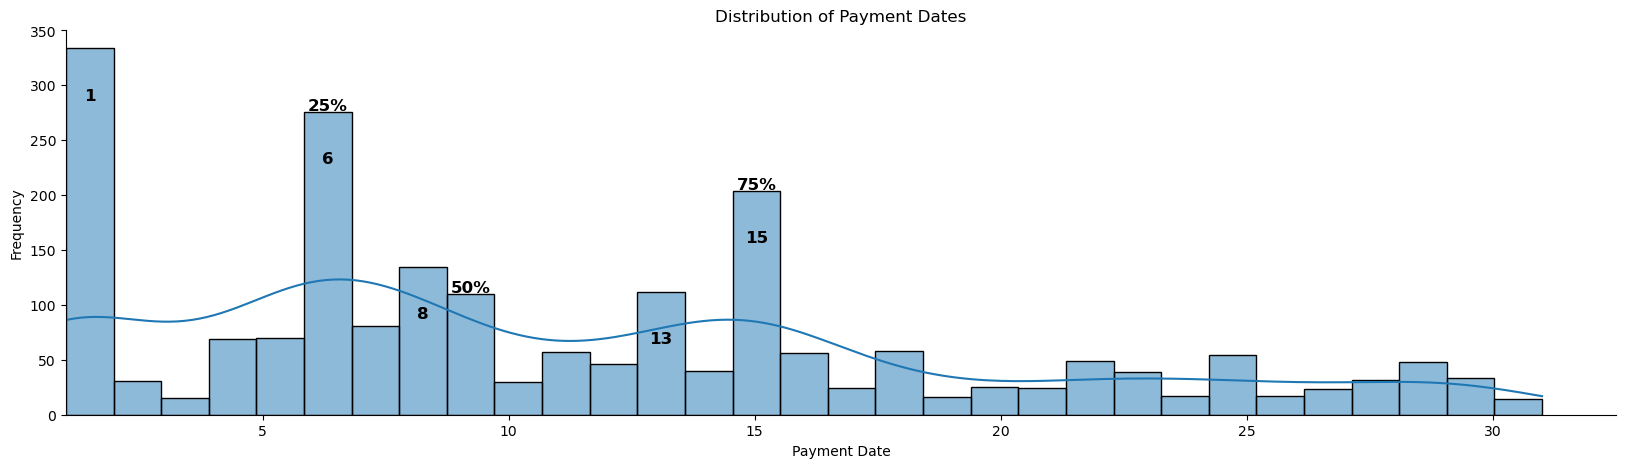

In [ ]:
def top_n_payment_dates_plot(payment_schedule_backend_table, top_n=5):
    
    main_observations = list(
        (
            payment_schedule_backend_table["payment_date"]
            .value_counts()
            .nlargest(top_n)
            .index.sort_values()
        )
    )

    # Plot distribution
    plt.figure(figsize=(20, 5))

    ax = sns.histplot(payment_schedule_backend_table["payment_date"], kde=True, bins=31)
    sns.despine(top=True, right=True)

    # Ensure x-axis starts at 0
    plt.xlim(left=1)

    # Add centered annotations inside the bins for main observation days
    for date in main_observations:
        for patch in ax.patches:
            if patch.get_x() <= date < patch.get_x() + patch.get_width():
                height = patch.get_height()
                center_x = patch.get_x() + (patch.get_width() / 2)  # Center text in the bin
                plt.text(center_x, 
                         height - 50,  # Adjust vertical position slightly above the bin
                         str(date), 
                         ha="center",
                         va="bottom", 
                         fontsize=12, 
                         color="black", 
                         fontweight="bold")

    # Calculate quantiles
    q25, q50, q75 = payment_schedule_backend_table["payment_date"].quantile([0.25, 0.5, 0.75])

    for quantile, label in zip([q25, q50, q75], ["25%", "50%", "75%"]):
        for patch in ax.patches:
            if patch.get_x() <= quantile < patch.get_x() + patch.get_width():
                height = patch.get_height()
                center_x = patch.get_x() + (patch.get_width() / 2)  # Center text in the bin
                plt.text(center_x, 
                         height + 1,  # Place slightly above the highest bin
                         label, 
                         ha="center", 
                         fontsize=12, 
                         color="black", 
                         fontweight="bold")

    plt.xlabel("Payment Date")
    plt.ylabel("Frequency")
    plt.title("Distribution of Payment Dates")
    plt.show()

# Run the function
top_n_payment_dates_plot(payment_schedule_backend_table)

#### `allowance_events` (JSON)  
This dataset captures the creation and updates of user allowances during the affected 
period.  
* Fields:  
  * `event.name`: The type of event, either `allowance.created` or  
`allowance.edited`.  
  * `event.timestamp`: Timestamp of the event.  
  * `user.id`: Unique identifier for the user.  
  * `allowance.amount`: Allowance amount.  
  * `allowance.scheduled.frequency`: Frequency of the allowance: 
`daily`, `weekly`, `biweekly`, or `monthly`.  
  * `allowance.scheduled.day`:  
    * `"daily"` for daily frequency.  
    * Day of the week for weekly/biweekly schedules.  
    * `"1st"` or `"15th"` for monthly schedules.

In [177]:
allowance_events['event.timestamp'] = allowance_events['event.timestamp'].apply(parse_unix_or_date)

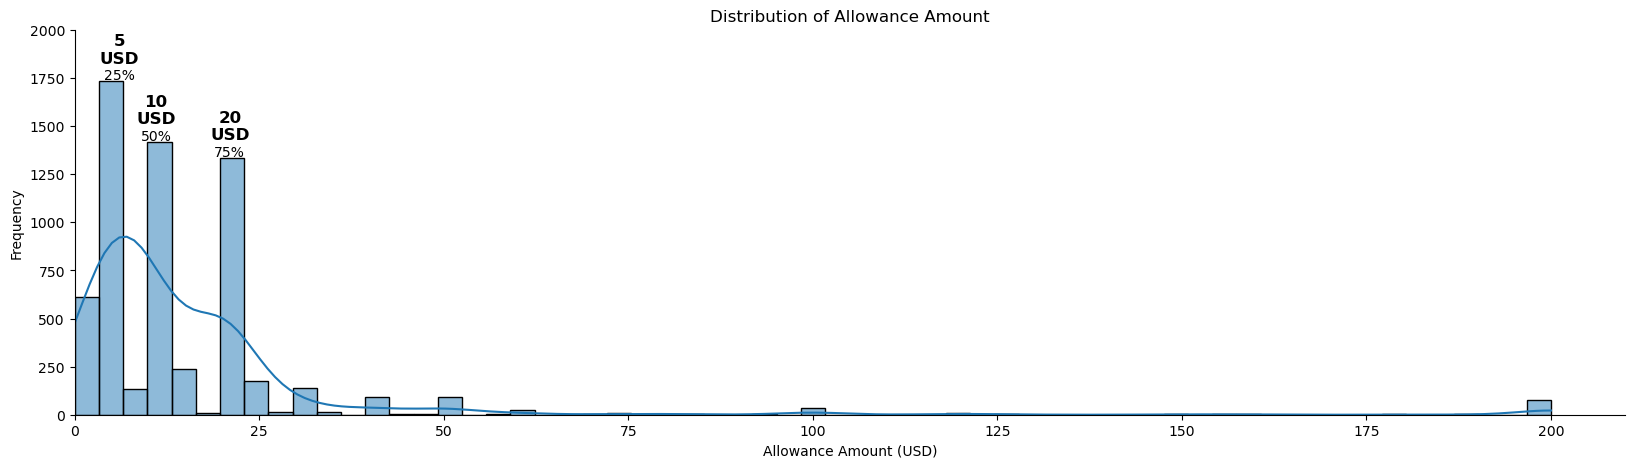

In [178]:
def top_n_allowances_plot(allowance_events, top_n=5):
    
    main_observations = list(
        (
            allowance_events["allowance.amount"]
            .value_counts()
            .nlargest(top_n)
            .index.sort_values()
        )
    )

    # Plot distribution
    plt.figure(figsize=(20, 5))
    ax = sns.histplot(allowance_events["allowance.amount"], 
                      kde=True, 
                      bins=allowance_events["allowance.amount"].unique().size)
    
    # Remove top and right plot borders
    sns.despine(top=True, right=True)

    # Ensure x-axis starts at 0
    plt.xlim(left=0)

    # Adjust y-axis limit to ensure space for annotations
    y_max = ax.get_ylim()[1] * 1.1  # Increase by 10% for better spacing
    plt.ylim(top=y_max)

    # Add annotations inside the bins for main observation allowance amounts
    for idx, val in enumerate(main_observations):
        max_bin_height = max([patch.get_height() for patch in ax.patches if patch.get_x() <= val < patch.get_x() + patch.get_width()], default=0)
        plt.text(val + 1, 
                 max_bin_height + (y_max * 0.04),  # Offset text above the bin
                 f"{val:.0f}\nUSD", 
                 ha="center",
                 va="bottom", 
                 fontsize=12, 
                 color="black", 
                 fontweight="bold")

    # Calculate quantiles
    q25, q50, q75 = allowance_events["allowance.amount"].quantile([0.25, 0.5, 0.75])

    for quantile, label in zip([q25, q50, q75], ["25%", "50%", "75%"]):
        max_bin_height = max([patch.get_height() for patch in ax.patches if patch.get_x() <= quantile < patch.get_x() + patch.get_width()], default=0)
        plt.text(quantile + 1, 
                 max_bin_height + 10, #- (y_max * 0.1),  # Offset text above the bin
                 label, 
                 ha="center", 
                 fontsize=10, 
                 color="black")

    plt.xlabel("Allowance Amount (USD)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Allowance Amount")
    plt.show()

top_n_allowances_plot(allowance_events, top_n=3)

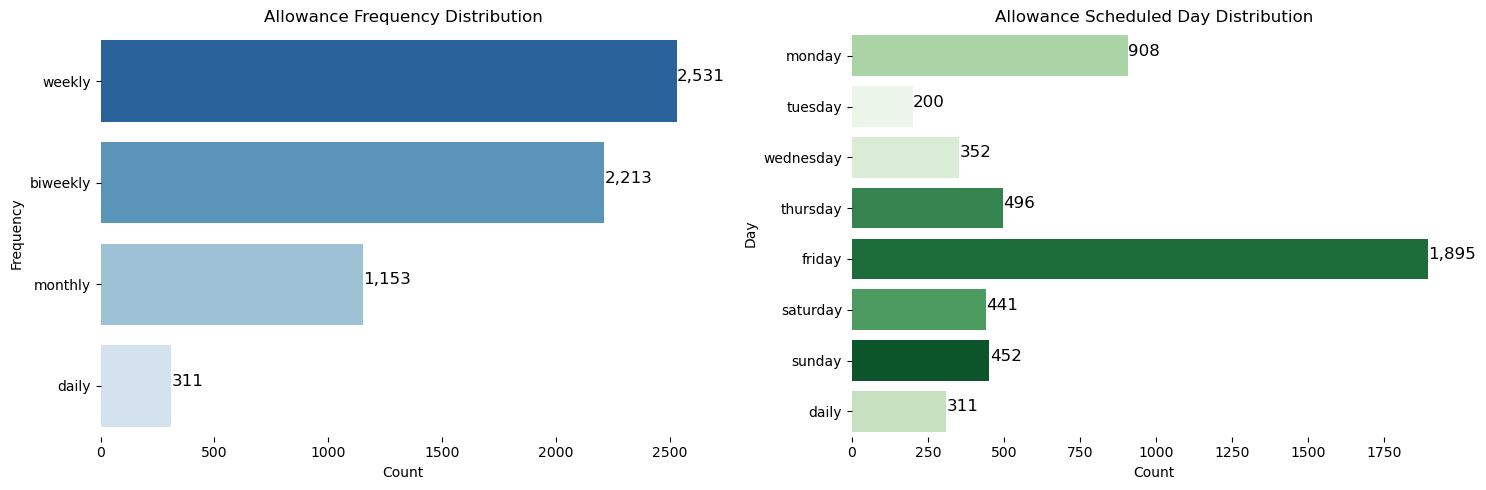

In [179]:
def plot_categorical_variables(allowance_events):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Frequency Plot
    sns.countplot(
        y="allowance.scheduled.frequency",
        data=allowance_events,
        order=allowance_events["allowance.scheduled.frequency"].value_counts().index,
        ax=axes[0],
        palette="Blues_r",
        hue="allowance.scheduled.frequency", 
        legend=False  
    )
    axes[0].set_title("Allowance Frequency Distribution")
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel("Frequency")
    sns.despine(left=True, bottom=True)

    # Annotate frequency bars
    for p in axes[0].patches:
        axes[0].annotate(f"{p.get_width():,.0f}", (p.get_width() + 2, p.get_y() + 0.4), fontsize=12, color="black")

    # Define ordered weekdays
    weekdays_order = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "daily"]

    # Day Plot
    sns.countplot(
        y="allowance.scheduled.day",
        data=allowance_events,
        order=[day for day in weekdays_order if day in allowance_events["allowance.scheduled.day"].unique()],
        ax=axes[1],
        palette="Greens_r",
        hue="allowance.scheduled.day", 
        legend=False  
    )
    axes[1].set_title("Allowance Scheduled Day Distribution")
    axes[1].set_xlabel("Count")
    axes[1].set_ylabel("Day")
    sns.despine(left=True, bottom=True)

    # Annotate day bars
    for p in axes[1].patches:
        axes[1].annotate(f"{p.get_width():,.0f}", (p.get_width() + 2, p.get_y() + 0.4), fontsize=12, color="black")

    plt.tight_layout()
    plt.show()

# Run the function
plot_categorical_variables(allowance_events)

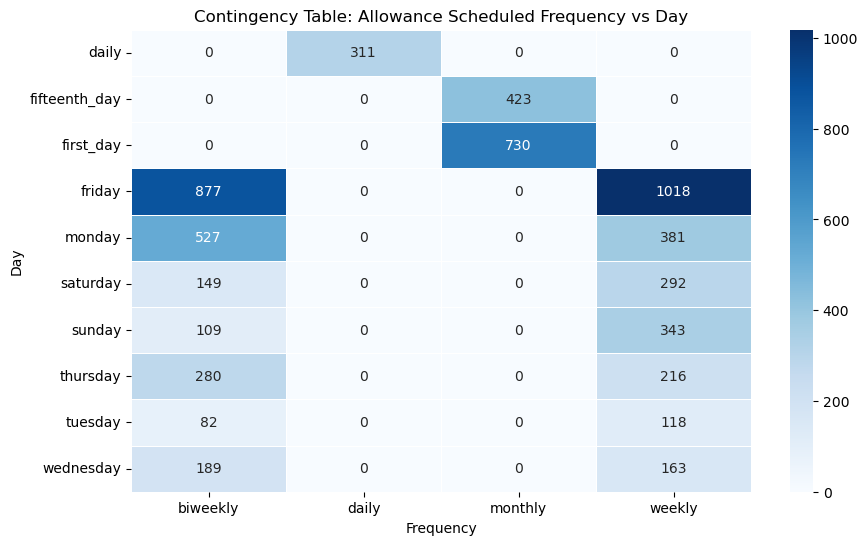

In [180]:
def plot_contingency_table(allowance_events):
    # Create the contingency table
    contingency_table = pd.crosstab(
        allowance_events["allowance.scheduled.day"], 
        allowance_events["allowance.scheduled.frequency"]
    )

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt="d", linewidths=0.5)

    # Titles and labels
    plt.title("Contingency Table: Allowance Scheduled Frequency vs Day")
    plt.xlabel("Frequency")
    plt.ylabel("Day")

    plt.show()

# Run the function
plot_contingency_table(allowance_events)

## 2. Solutions

The goal in this exercise is to generate a `allowance_backend_table` and `payment_schedule_backend_table` through the `allowance_events` logs.

Afterwards, compare the errors and infer patterns.

In [181]:
# Set the current day as December 3, 2024 (the reference date)
CURRENT_DATE = date(2024, 12, 3)

In [182]:
def normalize_scheduled_day(frequency: str, scheduled_day: str):
    """
    For monthly allowances, convert day strings into an integer.
    For weekly/biweekly, return a lowercase weekday.
    For daily, simply return "daily".
    """
    freq = frequency.lower()
    sd = scheduled_day.lower()
    if freq == "monthly":
        if sd in ["1st", "first_day"]:
            return 1
        elif sd in ["15th", "fifteenth_day"]:
            return 15
        else:
            # Attempt to extract numeric digits (e.g., "20th" -> 20)
            try:
                return int(''.join(filter(str.isdigit, sd)))
            except Exception as e:
                raise ValueError(f"Unrecognized monthly scheduled_day: {scheduled_day}") from e
    elif freq in ["weekly", "biweekly"]:
        return sd  # assume day names are provided, e.g., "monday", "sunday", etc.
    elif freq == "daily":
        return sd  # not used in calculation; placeholder
    else:
        raise ValueError(f"Unsupported frequency: {frequency}")

In [310]:
# Assuming CURRENT_DATE is defined elsewhere (e.g., CURRENT_DATE = date(2024, 12, 3))

def get_next_payment_date(frequency: str, scheduled_day, base_date: date, current_date=CURRENT_DATE) -> date:
    """
    Compute the next payment date based on the allowance frequency and scheduled day.
    
    For daily allowances, returns the next day.
    For weekly, uses the weekday name.
    For biweekly, schedules payments only on the first and third occurrence
      of the target weekday in the month.
    For monthly, uses the integer day (with month rollover if needed).
    """
    freq = frequency.lower()
    
    if freq == "daily":
        return current_date + timedelta(days=1)
    
    elif freq == "weekly":
        # Use the standard weekly logic.
        day_mapping = {
            "monday": 0,
            "tuesday": 1,
            "wednesday": 2,
            "thursday": 3,
            "friday": 4,
            "saturday": 5,
            "sunday": 6
        }
        target_weekday = day_mapping.get(scheduled_day.lower())
        if target_weekday is None:
            raise ValueError(f"Invalid scheduled_day for weekly: {scheduled_day}")
        days_ahead = (target_weekday - base_date.weekday() + 7) % 7
        if days_ahead == 0:
            days_ahead = 7
        return base_date + timedelta(days=days_ahead)
    
    elif freq == "biweekly":
        # Biweekly: Payment only on the first and third occurrence of scheduled_day in the month.
        day_mapping = {
            "monday": 0,
            "tuesday": 1,
            "wednesday": 2,
            "thursday": 3,
            "friday": 4,
            "saturday": 5,
            "sunday": 6
        }
        target_weekday = day_mapping.get(scheduled_day.lower())
        if target_weekday is None:
            raise ValueError(f"Invalid scheduled_day for biweekly: {scheduled_day}")
        
        # Define a helper to find the valid (1st and 3rd) occurrences in a given year/month.
        def valid_biweekly_dates(year: int, month: int):
            _, num_days = calendar.monthrange(year, month)
            weekday_dates = [date(year, month, d) for d in range(1, num_days + 1)
                             if date(year, month, d).weekday() == target_weekday]
            valid = []
            if len(weekday_dates) >= 1:
                valid.append(weekday_dates[0])  # first occurrence

            if len(weekday_dates) >= 3:
                valid.append(weekday_dates[2])  # third occurrence

            return valid
        
        # Check current month.
        year, month = current_date.year, current_date.month
        valid_dates = valid_biweekly_dates(year, month)
        for dt in valid_dates:
            if dt > current_date:
                return dt
        
        # If none found in the current month, move to the next month.
        next_month_date = current_date + relativedelta(months=1)
        year, month = next_month_date.year, next_month_date.month
        valid_dates = valid_biweekly_dates(year, month)
        if valid_dates:
            return valid_dates[0]
        
        else:
            raise ValueError("No valid biweekly payment date found in the next month.")
    
    elif freq == "monthly":
        # For monthly frequency, scheduled_day is expected to be an integer.
        day_num = scheduled_day  # already normalized as an integer.
        last_day = calendar.monthrange(base_date.year, base_date.month)[1]
        if base_date.day < day_num <= last_day:
            return date(base_date.year, base_date.month, day_num)
        
        else:
            next_month = base_date + relativedelta(months=1)
            last_day_next = calendar.monthrange(next_month.year, next_month.month)[1]
            day_to_use = min(day_num, last_day_next)
            return date(next_month.year, next_month.month, day_to_use)
    
    else:
        raise ValueError(f"Unsupported frequency: {frequency}")

In [311]:
def update_allowance_backend_table(original_df: pd.DataFrame, events_df: pd.DataFrame) -> pd.DataFrame:
    """
    Update the original allowance_backend_table using the events log.
    The following fields are updated using the latest event for each user:
        - frequency
        - day
        - updated_at
        - next_payment_day (computed from the expected next payment date)
    The original uuid, creation_date, and status fields remain unchanged.
    """
    # Ensure event.timestamp is in datetime format.
    events_df['event.timestamp'] = pd.to_datetime(events_df['event.timestamp'])
    
    # Compute the latest settings per user from events.
    computed = {}
    grouped = events_df.groupby('user.id')
    for user_id, group in grouped:
        # Latest event for this user
        latest_event = group.sort_values('event.timestamp').iloc[-1]
        frequency = latest_event['allowance.scheduled.frequency']
        raw_day = latest_event['allowance.scheduled.day']
        normalized_day = normalize_scheduled_day(frequency, raw_day)
        try:
            expected_date = get_next_payment_date(frequency, normalized_day, CURRENT_DATE)
        except Exception as e:
            expected_date = None
        updated_at = group['event.timestamp'].max()
        computed[user_id] = {
            'frequency': frequency,
            'day': raw_day,
            'next_payment_day': float(expected_date.day) if expected_date is not None else None,
            'updated_at': updated_at
        }
    
    # Update original rows where computed events exist.
    updated_rows = []
    for idx, row in original_df.iterrows():
        user_id = row['uuid']
        if user_id in computed:
            row['frequency'] = computed[user_id]['frequency']
            row['day'] = computed[user_id]['day']
            row['next_payment_day'] = computed[user_id]['next_payment_day']
            row['updated_at'] = computed[user_id]['updated_at']
        updated_rows.append(row)
    return pd.DataFrame(updated_rows)

In [312]:
def generate_payment_schedule_backend_table(allowance_backend_df: pd.DataFrame, only_enabled=True) -> pd.DataFrame:
    """
    For enabled allowances, generate the payment schedule record.
    Each user should have one active record with payment_date aligning with the allowance.
    """

    if only_enabled:
        allowance_backend_df = allowance_backend_df[allowance_backend_df['status'] == "enabled"]
        
    records = []
    for _, row in allowance_backend_df.iterrows():
        record = {
            "uuid": row['uuid'],
            "payment_date": row['next_payment_day']  # this is the day-of-month (float)
        }
        records.append(record)
    return pd.DataFrame(records)

In [313]:
events_df = allowance_events.copy()

allowance_backend_df = update_allowance_backend_table(allowance_backend_table, events_df)

payment_schedule_df = generate_payment_schedule_backend_table(allowance_backend_df)

In [314]:
def compare_backend_dfs(updated_df: pd.DataFrame, original_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compare two backend DataFrames (updated and original) and return a DataFrame listing differences.
    
    For each row (keyed by index) and each column in the original DataFrame,
    the function outputs:
      - the index (key),
      - the column name,
      - the original value,
      - and the updated value.
      
    An outer merge on the index is performed to handle cases where indices differ between the two DataFrames.
    
    Args:
        updated_df (pd.DataFrame): The DataFrame with updated records.
        original_df (pd.DataFrame): The original DataFrame.
    
    Returns:
        pd.DataFrame: A DataFrame with columns: 'index', 'column', 'original', 'updated'
                    for each difference found.
    """
    
    # Merge the two DataFrames on the index using an outer join.
    # Suffixes will help differentiate values coming from each DataFrame.
    merged = original_df.merge(
        updated_df,
        left_index=True,
        right_index=True,
        how='outer',
        suffixes=('_original', '_updated')
    )
    
    diff_records = []
    # Iterate over each row in the merged DataFrame.
    for idx, row in merged.iterrows():
        # Iterate over each column from the original DataFrame.
        for col in original_df.columns:
            original_val = row.get(col + "_original")
            updated_val  = row.get(col + "_updated")
            # Treat two NaN values as equal.
            if pd.isna(original_val) and pd.isna(updated_val):
                continue
            # If one value is NaN or the values differ, record the difference.
            if (pd.isna(original_val) and not pd.isna(updated_val)) or \
               (not pd.isna(original_val) and pd.isna(updated_val)) or \
               (original_val != updated_val):
                diff_records.append({
                    "uuid": idx,
                    "column": col,
                    "original": original_val,
                    "updated": updated_val
                })
    
    # Convert the list of difference records into a DataFrame.
    diff_df = pd.DataFrame(diff_records)
    diff_df = diff_df[diff_df['column'].isin(['next_payment_day', 'payment_date'])]
    return diff_df

#### `allowance_backend_table` update corrections: 

In [315]:
original_df = pd.DataFrame(allowance_backend_table).set_index('uuid')
updated_df = pd.DataFrame(allowance_backend_df).set_index('uuid')

allowance_diff_df = compare_backend_dfs(updated_df, original_df)
allowance_diff_df

,uuid,column,original,updated
1,00039f90-7331-401c-bcf1-72a4a9c42a18,next_payment_day,15,6.0
3,00139bdc-92b3-4ebd-af94-285acf2fd376,next_payment_day,13,4.0
5,0035bbe5-5034-40b6-aa8f-b50047f09dea,next_payment_day,12,7.0
7,004e441f-6f3f-425b-b450-eac1593495a0,next_payment_day,26,4.0
10,00947fea-2e47-44f7-8a2b-ed9fc7195a0a,next_payment_day,19,5.0
...,...,...,...,...
4520,ffa45e48-7b51-4953-a853-564e7ccdce3b,next_payment_day,9,4.0
4522,ffb657b0-c97b-46df-aa05-d3638a0d78a0,next_payment_day,12,5.0
4525,ffbee036-6d3c-4072-8998-3f0988353077,next_payment_day,22,6.0
4527,ffdbc130-089e-4a5e-8eb6-b687960d14a3,next_payment_day,16,6.0


In [316]:
test_df = allowance_backend_df[['uuid', 'frequency', 'day',  'next_payment_day', 'status']
                               ].merge(allowance_diff_df, how='left', on='uuid'
                                       ).merge(payment_schedule_df, how='left', on='uuid')

test_df[~(test_df['original'].isna()) & (test_df['status'] == 'enabled')].sample(10)

,uuid,frequency,day,next_payment_day,status,column,original,updated,payment_date
2857,6dd00878-1512-4d6a-aed8-8d3787c84521,biweekly,thursday,5.0,enabled,next_payment_day,12,5.0,5.0
1207,3d4f0b4f-e2a2-411f-9ea9-f2ede8f389f4,weekly,saturday,7.0,enabled,next_payment_day,12,7.0,7.0
1971,a33a20f1-381f-4d91-b65d-66424e65244a,weekly,friday,6.0,enabled,next_payment_day,15,6.0,6.0
2864,e55392c6-b5cb-459a-a4de-d34e870cfbf8,biweekly,friday,6.0,enabled,next_payment_day,13,6.0,6.0
1189,6b588731-dd54-4246-8f3f-1c0ebe812482,weekly,monday,9.0,enabled,next_payment_day,2,9.0,9.0
330,e5e5c20c-3002-467e-a41e-2f53824791b8,weekly,friday,6.0,enabled,next_payment_day,15,6.0,6.0
827,d103cbe2-a1db-4187-bb42-d2b197f0504e,weekly,friday,6.0,enabled,next_payment_day,8,6.0,6.0
2587,019b47d0-9d8b-4ef4-9079-43f36335888b,weekly,friday,6.0,enabled,next_payment_day,29,6.0,6.0
1633,eb8bc59b-1ad3-4b23-86b1-7a359e498b5f,biweekly,tuesday,17.0,enabled,next_payment_day,10,17.0,17.0
484,bc9cc077-022c-454a-b526-e40cc2ecbffd,biweekly,monday,16.0,enabled,next_payment_day,9,16.0,16.0


![Screenshot 2025-02-07 at 8.55.23 AM.png](<attachment:Screenshot 2025-02-07 at 8.55.23 AM.png>)
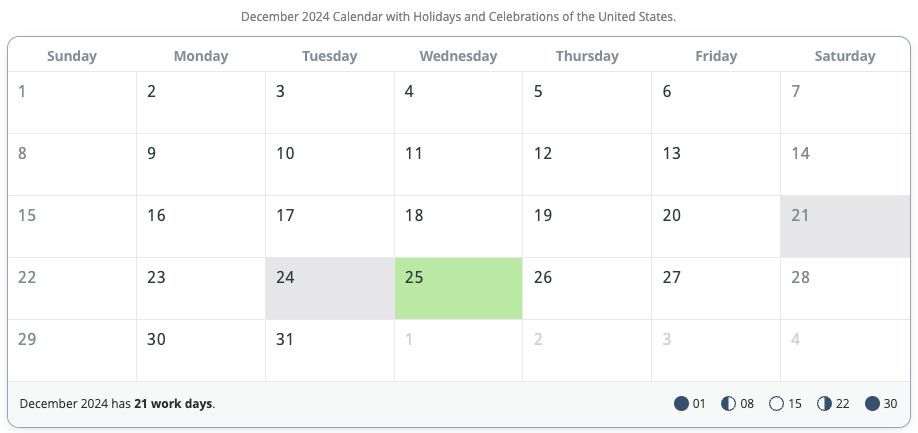

In [309]:
events_df[events_df['allowance.scheduled.frequency'] == 'biweekly']

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
3,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 06:32:28,allowance.created,biweekly,friday,10
8,bb724b84-64fc-45e5-8ece-e74122e6f4e8,2024-11-02 06:28:39,allowance.created,biweekly,thursday,20
9,bb724b84-64fc-45e5-8ece-e74122e6f4e8,2024-11-02 06:28:57,allowance.edited,biweekly,saturday,20
10,bb724b84-64fc-45e5-8ece-e74122e6f4e8,2024-11-02 06:28:57,allowance.edited,biweekly,saturday,20
12,14711807-513c-43e8-a715-5d8483249821,2024-10-06 08:15:39,allowance.created,biweekly,thursday,20
...,...,...,...,...,...,...
6201,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 06:59:07,allowance.created,biweekly,monday,5
6202,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 06:59:24,allowance.edited,biweekly,thursday,5
6203,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 06:59:25,allowance.edited,biweekly,thursday,5
6206,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 07:01:13,allowance.edited,biweekly,saturday,5


#### `payment_schedule_backend_table` update corrections: 

In [257]:
original_df = pd.DataFrame(payment_schedule_backend_table).set_index('uuid')
updated_df = pd.DataFrame(payment_schedule_df).set_index('uuid')

payment_diff_df = compare_backend_dfs(updated_df, original_df)
payment_diff_df

,uuid,column,original,updated
0,00039f90-7331-401c-bcf1-72a4a9c42a18,payment_date,15.0,6.0
1,004e441f-6f3f-425b-b450-eac1593495a0,payment_date,26.0,4.0
2,00947fea-2e47-44f7-8a2b-ed9fc7195a0a,payment_date,19.0,12.0
3,0158fb0c-e44c-443d-894d-80abb93a5f4d,payment_date,15.0,6.0
4,019b47d0-9d8b-4ef4-9079-43f36335888b,payment_date,29.0,6.0
...,...,...,...,...
1081,ff04e666-3737-42f1-a03c-1ae99a8f263c,payment_date,18.0,6.0
1082,ff3c5f02-1607-41b4-8a10-92cd586d61e8,payment_date,23.0,16.0
1083,ff92c32b-2c4c-49da-96d3-8220cd832637,payment_date,6.0,13.0
1084,ffa45e48-7b51-4953-a853-564e7ccdce3b,payment_date,9.0,4.0


In [274]:
payment_schedule_backend_table.merge(payment_diff_df, how='left', on='uuid'
                                     )#.merge(payment_schedule_df, how='left', on='uuid')

,uuid,payment_date,column,original,updated
0,061d8039-b332-40ca-b906-3514b06411c2,22,payment_date,22.0,6.0
1,0ca92d01-feed-42e5-b90c-299b615f9d3f,22,payment_date,22.0,6.0
2,160bcd2d-3ab0-4a60-9bfa-ccfcc1ee17e4,22,payment_date,22.0,13.0
3,1649fee7-c424-4fb7-ac84-db36e15e042a,22,payment_date,22.0,8.0
4,1d647703-874d-4744-b4de-6a5212518aa8,22,payment_date,22.0,13.0
...,...,...,...,...,...
2149,f184a04d-f1ed-4f70-93a4-19426423a476,14,NaN,NaN,NaN
2150,f348b2f8-d9ad-40fe-9e1c-dd7f84f00396,14,payment_date,14.0,12.0
2151,f9636ff4-a3d9-46f4-8418-bc8b512d6eee,14,payment_date,14.0,9.0
2152,f970b14b-7aa2-43b3-b626-287578e521e6,14,payment_date,14.0,7.0
